In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import nibabel as nib
import scipy.ndimage

In [3]:

def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, show=True, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    if show == True:
        plt.show()
    
    return axs


In [4]:
dcm_img=pydicom.dcmread('Data/Sag_FLAIR+FATSAT_CUBE_3/IM-0021-0071.dcm')

In [5]:
dcm_img_data = dcm_img.pixel_array

In [6]:
dcm_img_header = dcm_img.elements
dcm_img_header
#dcm_img.InversionTime

<bound method Dataset.elements of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.244.6945.3969092.27569.1380867370.330
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7238010.5.0.3.5.4
(0002, 0013) Implementation Version Name         SH: 'OSIRIX'
(0002, 0016) Source Application Entity Title     AE: 'MINI1'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.

In [52]:
# dimensioni dei voxel

# orizzontale
print(dcm_img.PixelSpacing)

# longitudinale
print(dcm_img.SliceThickness)

# rapporto d'aspetto dei voxel
ar = dcm_img.SliceThickness/dcm_img.PixelSpacing[0]


[1.0156, 1.0156]
1.2


In [7]:
dcm_img_data.shape

(256, 256)

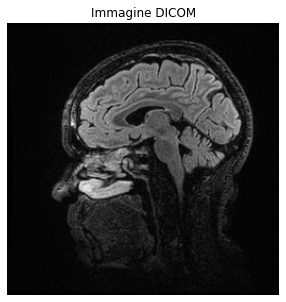

In [8]:
axes = plot_images([dcm_img_data],labels=['Immagine DICOM'])

In [9]:
def window(image, lower_threshold, upper_threshold):
    """
    Funzione che calcola la finestratura della dinamica di input
    per mapparla in [0 - 255]
    """
    
    # Saturiamo le soglie se sono fuori range rispetto all'immagine di ingresso
    if lower_threshold < np.min(image):
        lower_threshold = np.min(image)

    if upper_threshold > np.max(image):
        upper_threshold = np.max(image)

    # Creiamo la nuova immagine riempita di 1
    new_image = np.full_like(image, 1)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            # Applichiamo la trasformazione puntualmente
            new_image[i, j] = 0 if image[i, j] < lower_threshold \
                else 255 if image[i, j] > upper_threshold \
                else int(255*(image[i, j] - lower_threshold)/(upper_threshold - lower_threshold)) \
                if upper_threshold != lower_threshold else 255

    return new_image



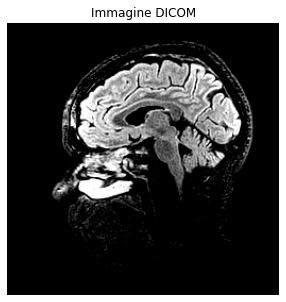

In [10]:
def window_and_plot(image, lower, upper):
    """
    Funzione wrapper per l'applicazione della trasformazione
    """
    dcm_img_transformed = window(image,lower,upper)

    plot_images([dcm_img_transformed],labels=['Immagine DICOM'])

window_and_plot(dcm_img_data,100,400)


In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output


def transform_image(image):
    """
    Funzione wrapper per utilizzo dell'interfaccia utente grafica
    su un'immagine qualsiasi
    """
    # estremi per la variazione degli slider
    minimum = np.min(image)
    maximum = np.max(image)
    
    w=interactive(window_and_plot,\
        image=fixed(image),\
        upper=widgets.IntSlider(min=minimum,max=maximum,value=250,continuous_update=True),\
        lower=widgets.IntSlider(min=minimum,max=maximum,value=50,continuous_update=True)\
        )
    
    clear_output()

    display(w)

In [12]:
%matplotlib inline
transform_image(dcm_img_data)

interactive(children=(IntSlider(value=50, description='lower', max=690), IntSlider(value=250, description='upp…

In [13]:
import os
import os.path

def load_dcm_volume(directory):
    """
    Funzione che carica un volume di dati DICOM da una cartella
    assumendo che questa contenga solamente un insieme di file .dcm
    """

    # leggiamo la lista dei file nella cartella
    files = os.listdir(directory)
    files.sort()
    
    # leggiamo il primo file per ottenere le dimensioni e il tipo della singola slice
    file = pydicom.dcmread(f'{directory}/{files[0]}')
    
    # creiamo il volume
    volume = np.full((len(files),file.pixel_array.shape[0],file.pixel_array.shape[1]),\
                    1,dtype=file.pixel_array.dtype)

    # carichiamo la prima slice, già letta, e successivamente le altre 
    volume[0,:,:] = file.pixel_array

    for i in range(1,len(files)):
        volume[i,:,:] = pydicom.dcmread(f'{directory}/{files[i]}').pixel_array
    
    return volume


In [24]:
dcm_volume = load_dcm_volume('Data/Sag_FLAIR+FATSAT_CUBE_3')

dcm_volume.shape

(136, 256, 256)

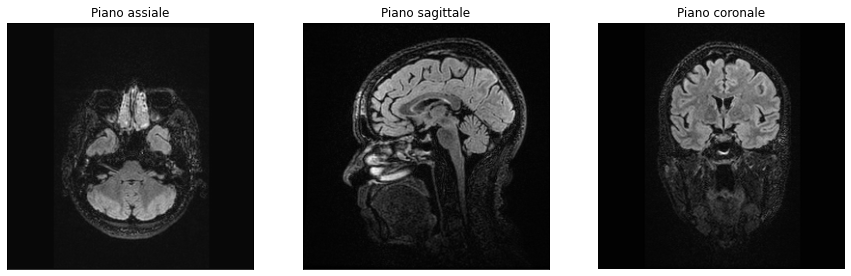

In [55]:
# Il volume è acquisito in maniera anisotropa lungo la direzione longitudinale
# Abbiamo già calcolato l'aspect ratio del voxel
# e inoltre gli assi puntano in direzoine oppopsta a quella convenzionale
# Serve una trasformazione T = S(ar) @ R(-90)

scale_m = np.array([[1.0, 0.0, 0.0],\
                    [0.0, ar, 0.0],\
                    [0.0, 0.0, 1.0]])

rot_m = np.array([[0.0, 1.0, 0.0],\
                  [-1.0, 0.0, 0.0],\
                  [0.0, 0.0, 1.0]])

trasl_m = np.array([[1.0, 0.0, 128.0],\
                    [0.0, 1.0, 128.0],\
                    [0.0, 0.0, 1.0]])


# La trasformazione complessiva tiene conto anche di una traslazione dell'origine al centro dell'immagine
t = trasl_m @ scale_m @ rot_m @ np.matrix(trasl_m).I

labels = ['Piano assiale', 'Piano sagittale', 'Piano coronale']

stack = np.ones((2,256,256))

stack[0] = scipy.ndimage.affine_transform(np.pad(dcm_volume[:,128,:],((60,60),(0,0)),'constant'),np.matrix(t).I)
stack[1] = scipy.ndimage.affine_transform(np.pad(dcm_volume[:,:,128],((60,60),(0,0)),'constant'),np.matrix(t).I)

images = [stack[0], dcm_volume[68,:,:], stack[1]]

axes = plot_images(images, labels=labels)